In [1]:
import pandas as pd
import numpy as np

SEED = 42
np.random.seed(SEED)

In [2]:
X = np.load('data/image_emb.npy')
y = pd.Series(np.load('data/image_labels.npy', allow_pickle=True))

cat_to_code = {v: k for k, v in enumerate(y.astype('category').cat.categories)}
y = np.array(y.map(cat_to_code))

In [3]:
from umap import UMAP

umap = UMAP(n_components=2, metric='cosine', random_state=SEED)
umap.fit(X)
X_2d = umap.transform(X)

/home/notuser/.pyenv/versions/workspace/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


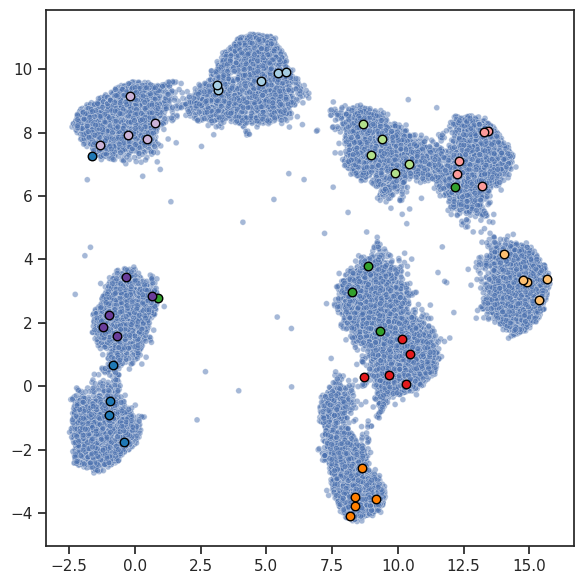

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='ticks')

def visualize_clusters(umap, X, y, clusters, labels):
    fig, ax = plt.subplots(figsize=(6, 6))
    X_2d = umap.transform(X)
    
    palette = None if y is None else 'Paired'
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], palette=palette,
                    hue=y, size=5, alpha=0.5, legend=False, ax=ax)

    colors = sns.color_palette("Paired", len(np.unique(labels)))
    nn_2d = umap.transform(clusters)

    for label, color in zip(np.unique(labels), colors):    
        i = labels == label
        ax.scatter(x=nn_2d[i, 0], y=nn_2d[i, 1], color=color, 
                edgecolor='black', linewidths=1, marker='.', s=150)
        
    fig.tight_layout()

idx = y == 0
visualize_clusters(umap, X[idx], None, X[~idx], y[~idx])

In [5]:
def centroids(X, y):
    labels = np.unique(y)[1:]
    centroids = np.empty((labels.shape[0], X.shape[1]))

    for i, label in enumerate(labels):
        centroids[i] = np.mean(X[y == label], axis=0)
        
    return labels, centroids

centroid_labels, centroids_ = centroids(X, y)

In [6]:
X_test = np.load('data/image_emb_test.npy')
y_test = pd.Series(np.load('data/image_labels_test.npy', allow_pickle=True))
y_test = np.array(y_test.map(cat_to_code))

Text(0.5, 1.0, 'NCC Silhouette Score: 0.255, Accuracy: 86.12%')

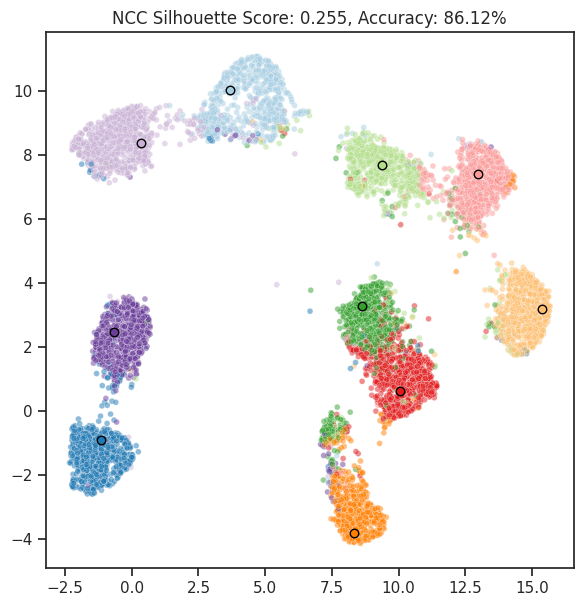

In [7]:
from sklearn.metrics import pairwise_distances_argmin, silhouette_score, accuracy_score

idx_pred = pairwise_distances_argmin(X_test, centroids_, metric='cosine')
y_pred_ncc = centroid_labels[idx_pred]

visualize_clusters(umap, X_test, y_pred_ncc, centroids_, centroid_labels)

ncc_score = silhouette_score(X_test, y_pred_ncc, metric='cosine', random_state=SEED)
ncc_accuracy = accuracy_score(y_pred_ncc, y_test)
plt.gca().set_title(f"NCC Silhouette Score: {ncc_score:.3f}, Accuracy: {ncc_accuracy:.2%}")

Text(0.5, 1.0, 'KNN Silhouette Score: 0.245, Accuracy: 84.12%')

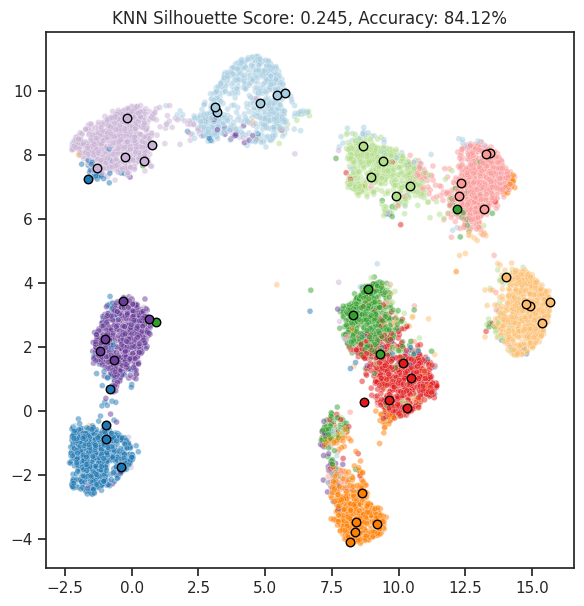

In [8]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(5, metric='cosine')

clusters, labels = X[y != 0], y[y != 0]
knn.fit(clusters, labels)

y_pred_knn = knn.predict(X_test)

visualize_clusters(umap, X_test, y_pred_knn, clusters, labels)

knn_score = silhouette_score(X_test, y_pred_knn, metric='cosine', random_state=SEED)
knn_accuracy = accuracy_score(y_pred_knn, y_test)
plt.gca().set_title(f"KNN Silhouette Score: {knn_score:.3f}, Accuracy: {knn_accuracy:.2%}")